In [1]:
from scipy.special import expit
from sklearn.decomposition import PCA
from imldiff.comparers import DifferenceComparer
from imldiff.model import Model
from imldiff.plots import plot_decision_boundaries, force_plot, get_force_plot_ordering, make_pca_embedding_values
from imldiff.toy_examples.explainers import SHAPExplainer
from imldiff.util import printmd
import shap
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
shap.initjs()

## Create Models

In [2]:
feature_names = ['x1', 'x2']

In [3]:
offset = 0.1
scale = 10

class Classifier(Model):
    def predict_proba(self, X):
        X = np.asarray(X)
        return np.array([expit((x[0] - offset/2) * scale) for x in X])

class ModifiedClassifier(Model):
    def predict_proba(self, X):
        X = np.asarray(X)
        return np.array([expit((x[0] + offset/2) * scale) for x in X])

In [4]:
number_of_samples = 1000
X = np.random.uniform(-1, 1, (number_of_samples, 2))
classifier = Classifier()
modified_classifier = ModifiedClassifier()
models = [classifier, modified_classifier]

In [5]:
predictions_a = classifier.predict_proba(X)
predictions_b = modified_classifier.predict_proba(X)
predictions = np.array([b - a for a, b in zip(predictions_a, predictions_b)])

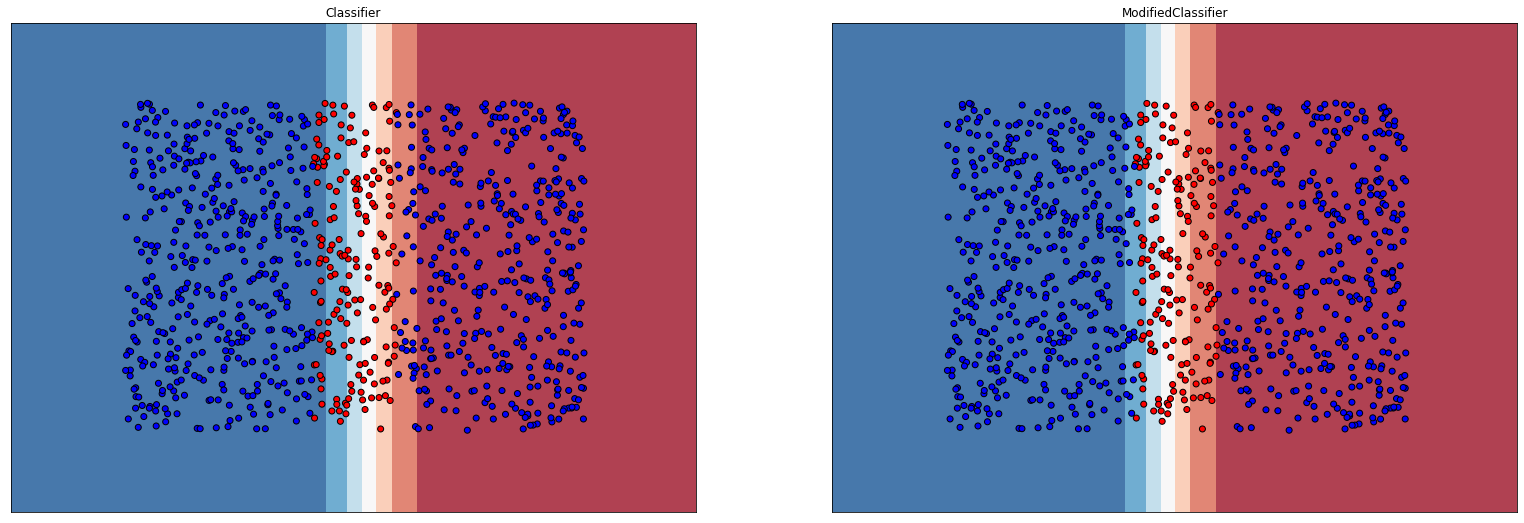

In [6]:
plot_decision_boundaries(models, X, predictions)

In [7]:
comparer = DifferenceComparer(classifier, modified_classifier)

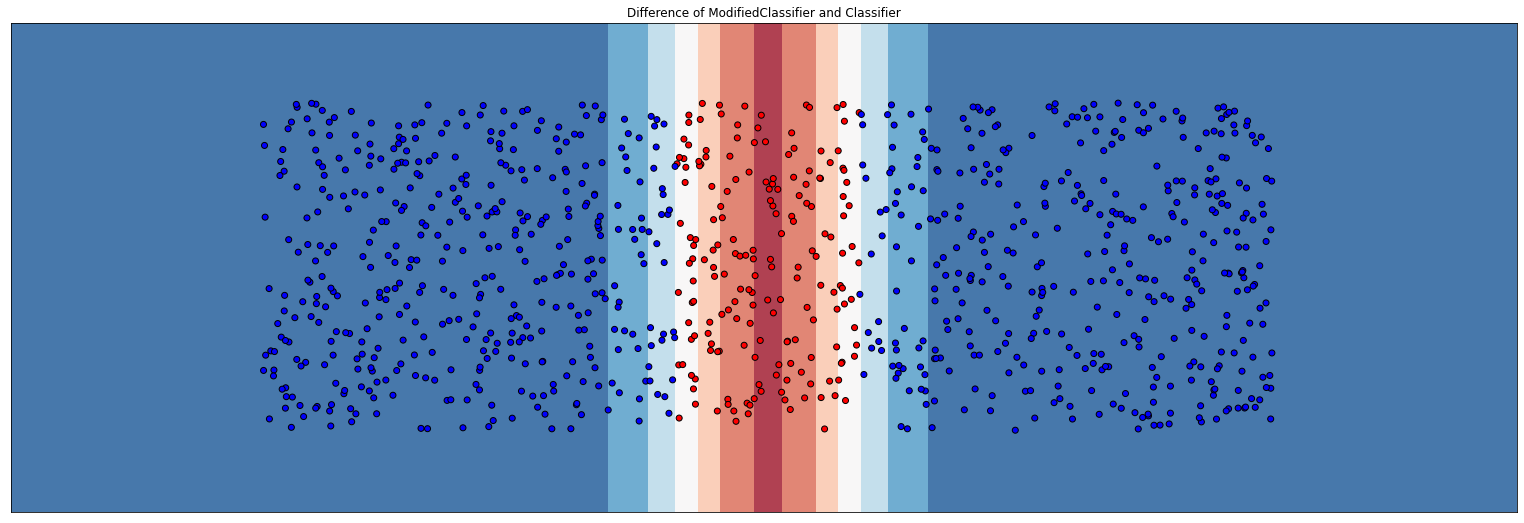

In [8]:
plot_decision_boundaries([comparer], X, predictions)

## Generate Explanations

In [9]:
notebook_name = 'Move Soft Decision Boundary'
comparison_explainer = SHAPExplainer(notebook_name + ' - Difference Model')
comparison_explainer.load_or_generate(comparer.predict_proba, X, feature_names=feature_names)
explainer_a = SHAPExplainer(notebook_name + ' - Model A')
explainer_a.load_or_generate(comparer.model_a.predict_proba, X, feature_names=feature_names)
explainer_b = SHAPExplainer(notebook_name + ' - Model B')
explainer_b.load_or_generate(comparer.model_b.predict_proba, X, feature_names=feature_names)
single_model_explainers = [explainer_a, explainer_b]
explainers = [explainer_a, explainer_b, comparison_explainer]

Loaded explanation: explanations/Move Soft Decision Boundary - Difference Model.exp
Loaded explanation: explanations/Move Soft Decision Boundary - Model A.exp
Loaded explanation: explanations/Move Soft Decision Boundary - Model B.exp


## Analyze

### Move Soft Decision Boundary - Model A

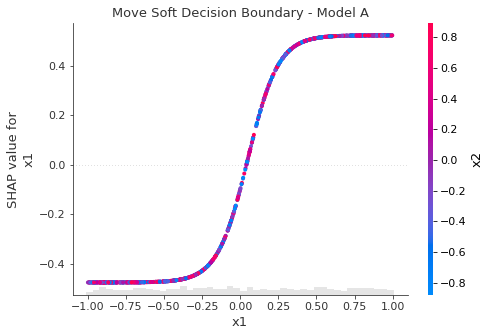

### Move Soft Decision Boundary - Model B

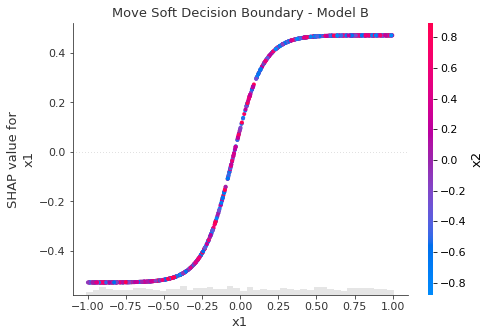

### Move Soft Decision Boundary - Difference Model

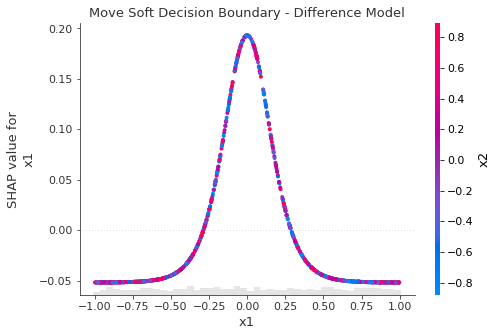

In [10]:
for explainer in explainers:
    printmd(f'### {explainer}')
    shap.plots.scatter(explainer.shap_values[:, feature_names[0]], color=explainer.shap_values, title=str(explainer))

### Move Soft Decision Boundary - Model A

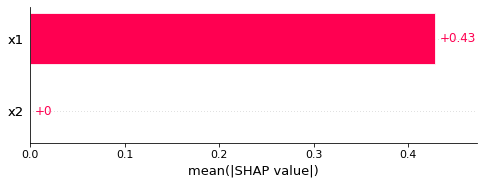

### Move Soft Decision Boundary - Model B

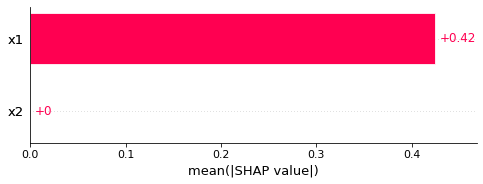

### Move Soft Decision Boundary - Difference Model

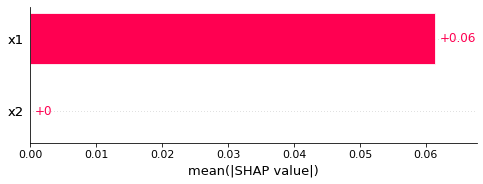

In [11]:
for explainer in explainers:
    printmd(f'### {explainer}')
    shap.plots.bar(explainer.shap_values)

### Move Soft Decision Boundary - Model A

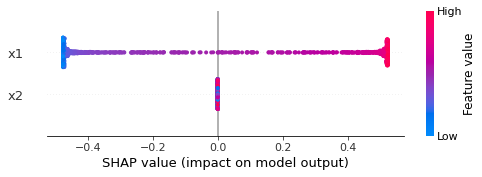

### Move Soft Decision Boundary - Model B

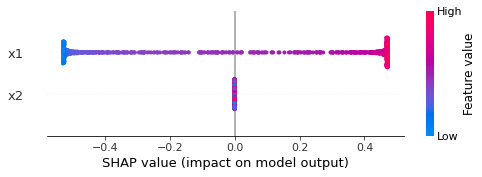

### Move Soft Decision Boundary - Difference Model

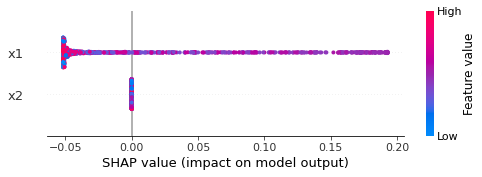

In [12]:
for explainer in explainers:
    printmd(f'### {explainer}')
    shap.plots.beeswarm(explainer.shap_values)

In [13]:
plot_a = force_plot(explainer_a)
ordering = get_force_plot_ordering(plot_a)
printmd(f'### {explainer_a}')
plot_a

### Move Soft Decision Boundary - Model A

In [14]:
printmd(f'### {explainer_b}')
force_plot(explainer_b, ordering)

### Move Soft Decision Boundary - Model B

In [15]:
printmd(f'### {comparison_explainer}')
force_plot(comparison_explainer)

### Move Soft Decision Boundary - Difference Model

### Move Soft Decision Boundary - Model A

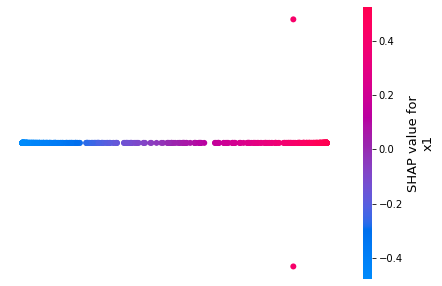

### Move Soft Decision Boundary - Model B

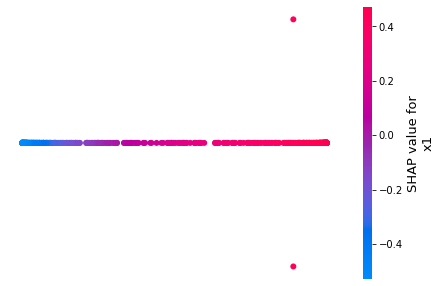

### Move Soft Decision Boundary - Difference Model

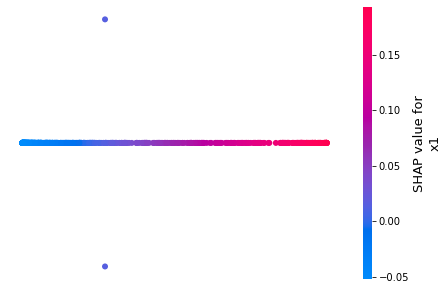

In [16]:
embedding_values = make_pca_embedding_values(explainer_a)
for explainer in single_model_explainers:
    printmd(f'### {explainer}')
    shap.plots.embedding(feature_names[0], explainer.shap_values.values, feature_names=feature_names, method=embedding_values)

printmd(f'### {comparison_explainer}')
shap.plots.embedding(feature_names[0], comparison_explainer.shap_values.values, feature_names=feature_names)

### Move Soft Decision Boundary - Model A

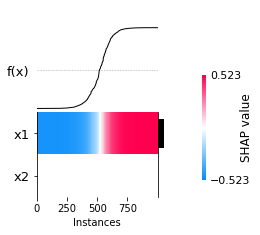

### Move Soft Decision Boundary - Model B

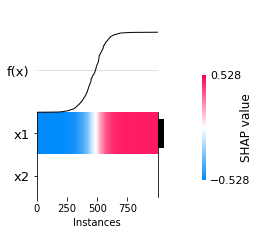

### Move Soft Decision Boundary - Difference Model

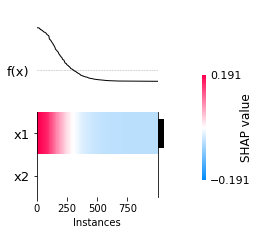

In [17]:
instance_order = explainer_a.shap_values.hclust()
feature_order = np.argsort(-explainer_a.shap_values.abs.mean(0).values)
for explainer in single_model_explainers:
    printmd(f'### {explainer}')
    shap.plots.heatmap(explainer.shap_values, instance_order=instance_order, feature_order=feature_order, max_display=len(feature_names))

printmd(f'### {comparison_explainer}')
shap.plots.heatmap(comparison_explainer.shap_values, max_display=len(feature_names))